# Week 7 Assignment

This week we are collecting some data from Reddit and doing some basic EDA on it. You should:

- create your Reddit account and API keys
- collect data from a subreddit of your choice
    - at a minimum, collect the posts from the subreddit; optionally collect comments on the posts
- save the data to a SQLite3 database
- perform some basic EDA on the data
    - create at least 2 plots
- write a short analysis at the end describing the process and results
- turn in the Jupyter Notebook and PDF printout or export to the week 7 dropbox

***Optional* advanced section**
- Practice SQL queries and select a subsection of the posts you collected
- Modify your code to collect data beyond the 1000 item limit
- Collect comments from the posts for analysis next week and do some EDA on the comments (e.g. who is the top commenter, which commenters have the most up and down votes or most controversial posts, etc)
- examine n-grams ([bigrams](https://stackoverflow.com/a/37651184/4549682), trigrams) or [collocations](https://www.geeksforgeeks.org/nlp-word-collocations/)

Note: There is no solution file for this week.

In [47]:
import praw
import pandas as pd
import sqlite3
import credentials

In [48]:
reddit = praw.Reddit(client_id=credentials.client_id,
                     client_secret=credentials.client_secret,
                     user_agent=credentials.user_agent)

## Discovery

In [49]:
sf_subreddit = reddit.subreddit('SustainableFashion').top(limit=25)

In [50]:
for post in sf_subreddit:
        print(post.title, post.score, post.num_comments, post.is_video, post.is_self, post.url)

What do you think about this Upcycled/Reworked Patagonia jacket? It was completely destroyed but I did some patchwork on it! 408 26 False False https://www.reddit.com/gallery/l6it87
Bernie’s memed mittens made by a teacher in Vermont 410 8 False False https://i.redd.it/b6vwqng5dkc61.jpg
Turned 3 old T-shirts into 1 new one ♻️♻️♻️ 357 17 False False https://www.reddit.com/gallery/i8jey0
Made some vintage-looking shorts out of thrifted men’s pants! 349 13 False False https://www.reddit.com/gallery/hz3j42
I reworked a $12 Thrifted Ralph Lauren Blazer into this Coco Chanel Inspired Set 💕 277 13 True False https://v.redd.it/imct6n16wk661
A jacket I created from my dads old clothes. Let me know what you think :) 277 22 False False https://www.reddit.com/gallery/m8bzbe
Another flour bag upcycled job. Lmk what you think :) 271 9 False False https://www.reddit.com/gallery/n7opvr
learned to sew this year in order to create a more sustainable (and unique!) wardrobe- this week i made my most compl

## Create DataFrame and SQL Table

In [51]:
from tqdm import tqdm

fields = {'title', 'link', 'author', 'n_comments', 'score', 'text', 'video', 'has-text', 'media-link', 'id'}
reddit_data = {k: [] for k in fields}
cols = {'author', 'score', 'text', 'post_id'}
reddit_comments_data = {k: [] for k in cols}


sf_subreddit = reddit.subreddit('SustainableFashion').top(limit=None)

for post in tqdm(list(sf_subreddit)):
    reddit_data['title'].append(post.title)
    reddit_data['link'].append(post.permalink)
    if post.author is None:
        reddit_data['author'].append('')
    else:
        reddit_data['author'].append(post.author.name)
    
    reddit_data['n_comments'].append(post.num_comments)
    reddit_data['score'].append(post.score)
    reddit_data['text'].append(post.selftext)
    reddit_data['video'].append(post.is_video)
    reddit_data['has-text'].append(post.is_self)
    reddit_data['media-link'].append(post.url)
    reddit_data['id'].append(post.id)
    
    post.comments.replace_more(limit=0)
    for comment in post.comments:
        if comment.author is None:
            reddit_comments_data['author'].append('')
        else:
            reddit_comments_data['author'].append(comment.author.name)
        reddit_comments_data['score'].append(comment.score)
        reddit_comments_data['text'].append(comment.body)
        reddit_comments_data['post_id'].append(post.id)

post_df = pd.DataFrame(reddit_data)
comment_df = pd.DataFrame(reddit_comments_data)

con = sqlite3.connect('sf_reddit.sqlite')
post_df.to_sql('posts', con, if_exists='replace')
comment_df.to_sql('comments', con, if_exists='replace')
con.close()

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [31:38<00:00,  1.90s/it]


## Data Prep and Cleaning

##### Below are functions I used to clean and reorganize the data. I have reoptimized the script a few times now so changes are already incorporated into the sql database, therefore these step are no longer needed for future iterations.

post_df = post_df.convert_dtypes()
post_df.info()

from sklearn import preprocessing


le = preprocessing.LabelEncoder()


post_df['video'] = le.fit_transform(post_df['video'])


post_df['has-text'] = le.fit_transform(post_df['has-text'])


post_df['media-link'] = post_df['media-link'].str.contains('gallery|jpg|png|i.redd.it|v.redd.it|img|image|gif|mp4|mov')


post_df['len_title'] = post_df['title'].str.len()


post_df['len_text'] = post_df['text'].str.len()

post_df['media-link'] = le.fit_transform(post_df['media-link'])

comment_df['len_text'] = comment_df['text'].str.len()

comment_df = comment_df.convert_dtypes()
comment_df.info()

In [75]:
post_df

,has-text,author,link,id,video,n_comments,title,score,text,media-link,len_title,len_text
0,0,boroboroclothing,/r/SustainableFashion/comments/l6it87/what_do_...,l6it87,0,26,What do you think about this Upcycled/Reworked...,412,,1,124,0
1,0,geminigirly,/r/SustainableFashion/comments/l1k9je/bernies_...,l1k9je,0,8,Bernie’s memed mittens made by a teacher in Ve...,407,,1,51,0
2,0,Bydanielpearce,/r/SustainableFashion/comments/i8jey0/turned_3...,i8jey0,0,17,Turned 3 old T-shirts into 1 new one ♻️♻️♻️,362,,1,43,0
3,0,stephmiche,/r/SustainableFashion/comments/hz3j42/made_som...,hz3j42,0,13,Made some vintage-looking shorts out of thrift...,349,,1,61,0
4,0,TaylerCmone,/r/SustainableFashion/comments/khmahw/i_rework...,khmahw,1,13,I reworked a $12 Thrifted Ralph Lauren Blazer ...,279,,1,82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,jabruce,/r/SustainableFashion/comments/o68ybq/check_ou...,o68ybq,0,0,Check out www.ozoneapparel.store - a fashion b...,5,,1,132,0
996,1,vildusmaximus,/r/SustainableFashion/comments/o2p2ki/y2k_fash...,o2p2ki,0,7,Y2k fashion?,5,Im in love with the y2k style. But its really ...,0,12,133
997,1,2littleduckscameback,/r/SustainableFashion/comments/o1jl4t/business...,o1jl4t,0,3,Business clothes,7,Does anyone have recommendations for sustainab...,0,16,210
998,1,kollaking,/r/SustainableFashion/comments/nkif13/linen_tr...,nkif13,0,0,Linen Trail - A Slow Fashion label from India ...,6,&#x200B; [Rasamalli Hand Embroidered Pure Lin...,0,103,1380


In [79]:
comment_df

,score,author,post_id,text,len_text
0,22,MissCasey,l6it87,This is dope! And honestly I bet Patagonia wou...,202
1,8,goodthingsinside_80,l6it87,So cool!,8
2,7,luvs2meow,l6it87,Love it!!! You’re very talented!! I’d love suc...,83
3,4,Balow08,l6it87,Beautiful renovation,20
4,3,kollegekidkardashian,l6it87,this is so cool! and fashionable,32
...,...,...,...,...,...
2884,7,jrizzle115,o1jl4t,My workplace is more on the business casual si...,223
2885,1,KCMasterpeirce,o1jl4t,The Good Trade publishes lists for ethical clo...,171
2886,5,wallace320,n1m9kh,For me it was learning about the environmental...,211
2887,2,,n1m9kh,I’ve not yet moved to purchasing sustainable b...,504


## Meaningful EDAs

<AxesSubplot:ylabel='Frequency'>

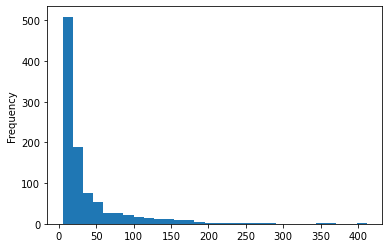

In [80]:
post_df['score'].plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>

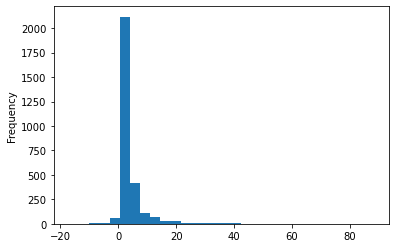

In [81]:
comment_df['score'].plot.hist(bins=30)

In [82]:
post_df[post_df['score'] > 400]

,has-text,author,link,id,video,n_comments,title,score,text,media-link,len_title,len_text
0,0,boroboroclothing,/r/SustainableFashion/comments/l6it87/what_do_...,l6it87,0,26,What do you think about this Upcycled/Reworked...,412,,1,124,0
1,0,geminigirly,/r/SustainableFashion/comments/l1k9je/bernies_...,l1k9je,0,8,Bernie’s memed mittens made by a teacher in Ve...,407,,1,51,0


In [83]:
comment_df[comment_df['score'] > 40]

,score,author,post_id,text,len_text
112,41,stmbt,htubx7,This post isn’t about opinions on the royals o...,503
417,59,BrownEyedGringa,o1mjso,I love this question!! Made me laugh Most sus...,470
762,88,,k8cp1q,Goodwill &#x200B; Edit: you can downvote me ...,77
1034,46,reesey_piecey,ld89qp,Creating lace is actually a long a tedious pro...,469
1104,74,babycaboose,kxwrrk,This is...interesting,21
1105,70,platypuseggnog,kxwrrk,"Hi, just a quick question: why?? Also wtf is t...",103
1154,51,IntoLaurel,p3l8ak,Usually I start with: “Than stop consuming.” I...,384
1429,41,JametAllDay,orrp57,"Tbh, shopping used can be hard depending on wh...",277
1618,42,,oese5q,Clothing from a sustainable line is great if y...,385
2084,71,raccoontails,ii3h0t,"Sustainable fashion isn’t expensive, it’s that...",430


In [84]:
comment_df[comment_df['score'] < 0]

,score,author,post_id,text,len_text
42,-2,asdf346,hz3j42,This is where all the men’s clothes go at the ...,60
120,-13,slugbabyrat,htubx7,Using a dress 2 (!) whole times in 60 years? T...,74
504,-12,tayloline29,nks5rb,It’s kind off shitty when people who don’t nee...,156
556,-3,marcus_cole_b5,muby9c,what a waste of resources. yes your creative b...,64
576,-4,Weshnon,lsti5r,You're looking for r/malefashion,32
757,-1,Weshnon,kz8l17,I'm not sure that just cutting off the bottom ...,117
798,-6,,hvmalf,[deleted],9
820,-1,scarletoarah,hr2jfd,cottage core? geez - also made in china,39
860,-4,marcus_cole_b5,occ3qa,Why bother looks Shiite. be better to just read.,48
908,-5,pickyflowerwow,gwf6r2,If you would like to check for more sustainabl...,94


I wonder what goes into a person's comment being downvoted rather than reported or banned.

### SQL sorting

In [ ]:
import sqlite3

In [137]:
conn = sqlite3.connect('sf_reddit.sqlite')
sql = ('''SELECT * 
        FROM posts
        INNER JOIN comments
        ON posts.id = comments.post_id;''')
results = conn.execute(sql).fetchall()
joined_sql = pd.DataFrame(data=results)
joined_sql.to_sql('compiled', con=conn, if_exists='append')
conn.close()

In [138]:
joined_sql = joined_sql.convert_dtypes()
joined_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2889 entries, 0 to 2888
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2889 non-null   Int64 
 1   1       2889 non-null   Int64 
 2   2       2889 non-null   string
 3   3       2889 non-null   string
 4   4       2889 non-null   string
 5   5       2889 non-null   Int64 
 6   6       2889 non-null   Int64 
 7   7       2889 non-null   string
 8   8       2889 non-null   Int64 
 9   9       2889 non-null   string
 10  10      2889 non-null   string
 11  11      2889 non-null   Int64 
 12  12      2889 non-null   Int64 
 13  13      2889 non-null   string
 14  14      2889 non-null   string
 15  15      2889 non-null   string
dtypes: Int64(7), string(9)
memory usage: 381.0 KB


In [139]:
joined_sql[10] = joined_sql[10].str.contains('gallery|jpg|png|i.redd.it|v.redd.it|img|image|gif|mp4|mov')

In [140]:
joined_sql[10] = le.fit_transform(joined_sql[10])

In [141]:
joined_sql[16] = joined_sql[15].str.len()

In [143]:
joined_sql.drop(columns={0,11,14}, inplace=True)

In [156]:
joined_sql['Post title len'] = joined_sql['Post title'].str.len()
joined_sql['Post text len'] = joined_sql['Post text'].str.len()

In [157]:
joined_sql.rename(columns={1:'Post has text', 2:'Post author', 3:'Post link', 4:'Post id', 5:'Post has video',
                           6:'Post_n_comments', 7:'Post title',8:'Post score',9:'Post text',10:'Media-link',
                           12:'Comment score',13:'Comment Author',14:'Comment Post ID',15:'Comment Text',16:'Comment length'}, inplace=True)
joined_sql

,Post has text,Post author,Post link,Post id,Post has video,Post_n_comments,Post title,Post score,Post text,Media-link,Comment score,Comment Author,Comment Text,Comment length,Post title len,Post text len
0,0,boroboroclothing,/r/SustainableFashion/comments/l6it87/what_do_...,l6it87,0,26,What do you think about this Upcycled/Reworked...,412,,1,22,MissCasey,This is dope! And honestly I bet Patagonia wou...,202,124,0
1,0,boroboroclothing,/r/SustainableFashion/comments/l6it87/what_do_...,l6it87,0,26,What do you think about this Upcycled/Reworked...,412,,1,8,goodthingsinside_80,So cool!,8,124,0
2,0,boroboroclothing,/r/SustainableFashion/comments/l6it87/what_do_...,l6it87,0,26,What do you think about this Upcycled/Reworked...,412,,1,7,luvs2meow,Love it!!! You’re very talented!! I’d love suc...,83,124,0
3,0,boroboroclothing,/r/SustainableFashion/comments/l6it87/what_do_...,l6it87,0,26,What do you think about this Upcycled/Reworked...,412,,1,4,Balow08,Beautiful renovation,20,124,0
4,0,boroboroclothing,/r/SustainableFashion/comments/l6it87/what_do_...,l6it87,0,26,What do you think about this Upcycled/Reworked...,412,,1,3,kollegekidkardashian,this is so cool! and fashionable,32,124,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,1,2littleduckscameback,/r/SustainableFashion/comments/o1jl4t/business...,o1jl4t,0,3,Business clothes,7,Does anyone have recommendations for sustainab...,0,7,jrizzle115,My workplace is more on the business casual si...,223,16,210
2885,1,2littleduckscameback,/r/SustainableFashion/comments/o1jl4t/business...,o1jl4t,0,3,Business clothes,7,Does anyone have recommendations for sustainab...,0,1,KCMasterpeirce,The Good Trade publishes lists for ethical clo...,171,16,210
2886,1,These_Lingonberry_22,/r/SustainableFashion/comments/n1m9kh/what_get...,n1m9kh,0,10,What gets you started to love sustainable brands?,7,Just wanted to know a little bit more about wh...,0,5,wallace320,For me it was learning about the environmental...,211,49,821
2887,1,These_Lingonberry_22,/r/SustainableFashion/comments/n1m9kh/what_get...,n1m9kh,0,10,What gets you started to love sustainable brands?,7,Just wanted to know a little bit more about wh...,0,2,,I’ve not yet moved to purchasing sustainable b...,504,49,821


In [146]:
joined_sql[joined_sql['Comment score'] > 60]['Post link'].to_list()

['/r/SustainableFashion/comments/k8cp1q/looking_for_sustainable_brands_with_a_similar/',
 '/r/SustainableFashion/comments/kxwrrk/hi_i_made_vegan_leather_clothing_out_of_dried_out/',
 '/r/SustainableFashion/comments/kxwrrk/hi_i_made_vegan_leather_clothing_out_of_dried_out/',
 '/r/SustainableFashion/comments/ii3h0t/why_sustainable_fashion_is_so_expensive/']

In [145]:
joined_sql[joined_sql['Post score'] > 400]['Post link'].to_list()

['/r/SustainableFashion/comments/l6it87/what_do_you_think_about_this_upcycledreworked/',
 '/r/SustainableFashion/comments/l6it87/what_do_you_think_about_this_upcycledreworked/',
 '/r/SustainableFashion/comments/l6it87/what_do_you_think_about_this_upcycledreworked/',
 '/r/SustainableFashion/comments/l6it87/what_do_you_think_about_this_upcycledreworked/',
 '/r/SustainableFashion/comments/l6it87/what_do_you_think_about_this_upcycledreworked/',
 '/r/SustainableFashion/comments/l6it87/what_do_you_think_about_this_upcycledreworked/',
 '/r/SustainableFashion/comments/l6it87/what_do_you_think_about_this_upcycledreworked/',
 '/r/SustainableFashion/comments/l6it87/what_do_you_think_about_this_upcycledreworked/',
 '/r/SustainableFashion/comments/l6it87/what_do_you_think_about_this_upcycledreworked/',
 '/r/SustainableFashion/comments/l6it87/what_do_you_think_about_this_upcycledreworked/',
 '/r/SustainableFashion/comments/l6it87/what_do_you_think_about_this_upcycledreworked/',
 '/r/SustainableFashi

<AxesSubplot:>

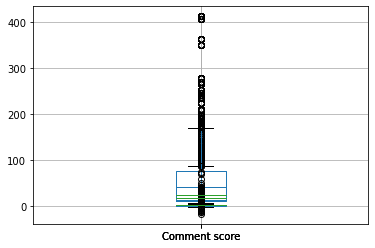

In [154]:
post_df.boxplot('score')
joined_sql.boxplot('Post score')
joined_sql.boxplot('Comment score')

I love sql for enhancing the data visualization as well as predictive analyses by way of layering. I have one dataset for just the top post scores from the subreddit, another for the top comments, and one that is these tables joined through SQL based on the post id. These all show separate information. The joined sql can analyze the weight of the comment scores on top posts more clearly than the two separate dataframes could alone. You can also extract many differnt table configurations to answer different questions based on the data.

<AxesSubplot:xlabel='Comment score', ylabel='Post score'>

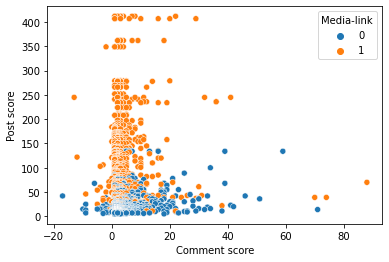

In [162]:
import seaborn as sns

sns.scatterplot(data=joined_sql, x='Comment score', y='Post score', hue='Media-link')

<AxesSubplot:xlabel='score', ylabel='n_comments'>

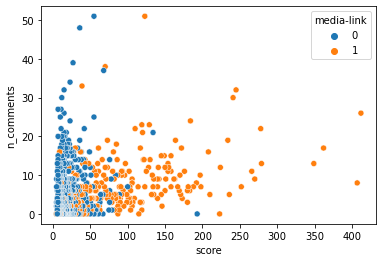

In [167]:
sns.scatterplot(data=post_df, x='score', y='n_comments', hue='media-link')

<AxesSubplot:xlabel='Post score', ylabel='Count'>

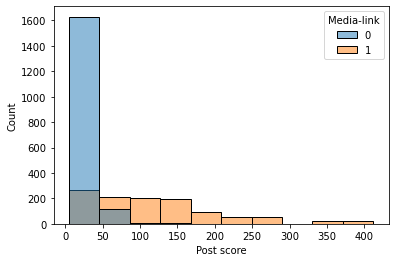

In [171]:
sns.histplot(joined_sql, x='Post score', hue='Media-link', bins=10)

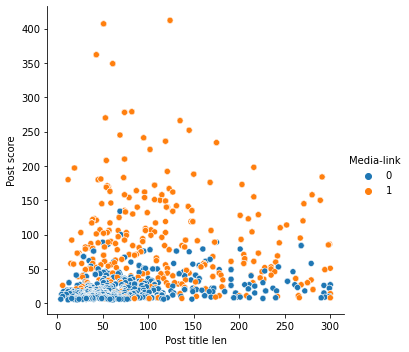

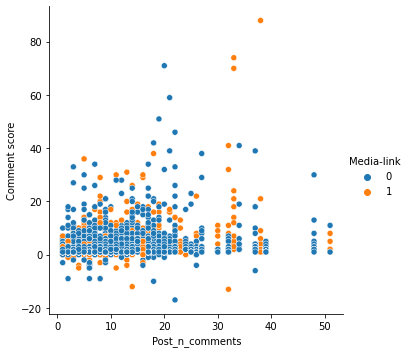

In [173]:
sns.relplot(data=joined_sql, x="Post title len", y="Post score", hue='Media-link')
sns.relplot(data=joined_sql, x="Post_n_comments", y="Comment score", hue='Media-link')

## I wondered about the top words used in the titles of posts

In [177]:
import nltk
from nltk.corpus import stopwords

stops = stopwords.words('english')
stops = set(stops) | set({"-", "&", "sustainable", "fashion", "really"})
sf_posttitle_words = ' '.join(joined_sql['Post title']).lower().split()
sf_commenttext_words = ' '.join(joined_sql['Comment Text']).lower().split()
post_words = [w for w in sf_posttitle_words if w not in set(stops)]
comment_words = [w for w in sf_commenttext_words if w not in set(stops)]

fd_post = nltk.FreqDist(post_words)
fd_comment = nltk.FreqDist(comment_words)

In [178]:
fd_post.most_common(20)

[('made', 468),
 ('brands', 275),
 ('clothing', 225),
 ('old', 182),
 ('new', 147),
 ('brand', 147),
 ('clothes', 135),
 ('ethical', 135),
 ('looking', 130),
 ('like', 120),
 ('know', 119),
 ('make', 108),
 ('think', 106),
 ('love', 99),
 ('would', 98),
 ('upcycled', 94),
 ('brands?', 90),
 (':)', 89),
 ('thrift', 86),
 ('dress', 83)]

In [179]:
fd_comment.most_common(20)

[('like', 497),
 ('love', 382),
 ('would', 349),
 ('also', 335),
 ('brands', 315),
 ('good', 288),
 ('made', 258),
 ('think', 246),
 ('make', 246),
 ('great', 242),
 ('clothes', 230),
 ('people', 224),
 ('brand', 222),
 ('get', 216),
 ('one', 213),
 ('buy', 213),
 ('it’s', 202),
 ('know', 192),
 ('look', 189),
 ('find', 188)]

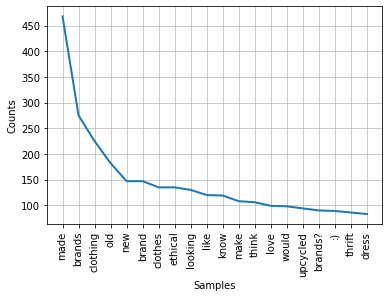

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [181]:
fd_post.plot(20)

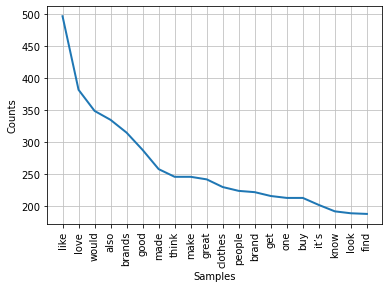

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [180]:
fd_comment.plot(20)

# Analysis

This process was very interesting and left me wanting more. I practiced joining sql tables, reorganizing, running text-analysis, adding and removing columns, creating edas. I really like how the inclusion of sql makes the data preperation side much easier and saving the data much more convenient. Though I am noticing I need to load my git conmmits more frequently based on the optimizations I try, so I have something to bo back to if it fails. 

As for results I did find that more negative comments that were demeaning and maybe hurtful had the greatest number of negative comment scores. Also, posts with images have greater post scores. I will continue to find insights now that I am better at prepping the data.